In [33]:
# ============================================================
# COVID-19 + World Happiness (2020) Analysis
# ============================================================
# Loads COVID-19 confirmed & deaths (JHU wide format),
# reshapes to long, aggregates yearly totals,
# merges with 2020 World Happiness report,
# and produces EDA plots + correlation heatmap.
# ============================================================

# ----------------------------
# 0) Imports & basic settings
# ----------------------------
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

In [34]:
# ----------------------------
# 1) Load data
# ----------------------------
CONFIRMED_PATH = "/Users/jannatrahman/your_project/data/covid19_Confirmed_dataset.csv"
DEATHS_PATH    = "/Users/jannatrahman/your_project/data/covid19_deaths_dataset.csv"
HAPPY_PATH     = "/Users/jannatrahman/your_project/data/worldwide_happiness_report.csv"

confirmed_raw = pd.read_csv(CONFIRMED_PATH)
deaths_raw    = pd.read_csv(DEATHS_PATH)
happy_raw     = pd.read_csv(HAPPY_PATH)

print("Confirmed shape:", confirmed_raw.shape)
print("Deaths shape:", deaths_raw.shape)
print("Happiness shape:", happy_raw.shape)


Confirmed shape: (266, 104)
Deaths shape: (266, 104)
Happiness shape: (156, 9)


In [35]:
# ---------------------------------------------
# 2) Reshape COVID: wide (dates as columns) → long
# ---------------------------------------------
date_cols_conf = confirmed_raw.columns[4:]
date_cols_dea  = deaths_raw.columns[4:]

confirmed_long = confirmed_raw.melt(
    id_vars=["Province/State","Country/Region","Lat","Long"],
    value_vars=date_cols_conf,
    var_name="date",
    value_name="confirmed"
)
deaths_long = deaths_raw.melt(
    id_vars=["Province/State","Country/Region","Lat","Long"],
    value_vars=date_cols_dea,
    var_name="date",
    value_name="deaths"
)

# Parse date
confirmed_long["date"] = pd.to_datetime(confirmed_long["date"], format="%m/%d/%y", errors="coerce")
deaths_long["date"]    = pd.to_datetime(deaths_long["date"],    format="%m/%d/%y", errors="coerce")

# Drop unparsable rows
confirmed_long = confirmed_long.dropna(subset=["date"])
deaths_long    = deaths_long.dropna(subset=["date"])

# Merge confirmed+deaths
covid_long = pd.merge(
    confirmed_long[["Country/Region","Province/State","date","confirmed"]],
    deaths_long[["Country/Region","Province/State","date","deaths"]],
    on=["Country/Region","Province/State","date"],
    how="outer"
)

# Derive year
covid_long["year"] = covid_long["date"].dt.year


In [36]:
# ---------------------------------------------
# 3) Aggregate by country-year
# ---------------------------------------------
covid_yearly = (
    covid_long
    .groupby(["Country/Region","year","date"], as_index=False)
    .agg(confirmed=("confirmed","sum"), deaths=("deaths","sum"))
    .sort_values(["Country/Region","year","date"])
)

# Keep last (max date) per country-year
covid_yearly_last = (
    covid_yearly
    .groupby(["Country/Region","year"], as_index=False)
    .tail(1)[["Country/Region","year","confirmed","deaths"]]
    .reset_index(drop=True)
)

print("\nCOVID yearly sample:")
print(covid_yearly_last.head())


COVID yearly sample:
  Country/Region  year  confirmed  deaths
0    Afghanistan  2020       2171      64
1        Albania  2020        773      31
2        Algeria  2020       4006     450
3        Andorra  2020        745      42
4         Angola  2020         27       2


In [37]:
# ---------------------------------------------
# 4) Clean Happiness (2020)
# ---------------------------------------------
happy = happy_raw.rename(columns={
    "Overall rank": "overall_rank",
    "Country or region": "country_or_region",
    "Score": "score",
    "GDP per capita": "gdp_per_capita",
    "Social support": "social_support",
    "Healthy life expectancy": "healthy_life_expectancy",
    "Freedom to make life choices": "freedom_to_make_life_choices",
    "Generosity": "generosity",
    "Perceptions of corruption": "perceptions_of_corruption"
})

# Add year (2020 snapshot)
happy["year"] = 2020

In [38]:
# ---------------------------------------------
# 5) Normalize country names
# ---------------------------------------------
def normalize_country_name(name: str) -> str:
    if pd.isna(name):
        return ""
    s = str(name).strip().lower()
    for ch in [",", "(", ")", "*", ".", "'", "-", "_"]:
        s = s.replace(ch, "")
    s = s.replace("&", "and")
    s = s.replace("  ", " ")
    return s

REPLACE_MAP = {
    "us": "united states",
    "korea south": "south korea",
    "russia": "russian federation",
    "czechia": "czech republic",
    "brunei": "brunei darussalam",
    "lao peoples democratic republic": "laos",
    "myanmar": "myanmar",
    "congo kinshasa": "democratic republic of the congo",
    "congo brazzaville": "congo",
}

covid_yearly_last["country_norm"] = (
    covid_yearly_last["Country/Region"].map(normalize_country_name).replace(REPLACE_MAP)
)
happy["country_norm"] = (
    happy["country_or_region"].map(normalize_country_name).replace(REPLACE_MAP)
)

In [39]:
# ---------------------------------------------
# 6) Merge COVID + Happiness
# ---------------------------------------------
merged = pd.merge(
    covid_yearly_last,
    happy,
    left_on=["country_norm","year"],
    right_on=["country_norm","year"],
    how="inner"
)

merged["country"] = merged["country_or_region"]

print("\nMerged shape:", merged.shape)
print(merged[["country","year","confirmed","deaths","score","gdp_per_capita"]].head())


Merged shape: (148, 15)
       country  year  confirmed  deaths  score  gdp_per_capita
0  Afghanistan  2020       2171      64  3.203           0.350
1      Albania  2020        773      31  4.719           0.947
2      Algeria  2020       4006     450  5.211           1.002
3    Argentina  2020       4428     218  6.086           1.092
4      Armenia  2020       2066      32  4.559           0.850


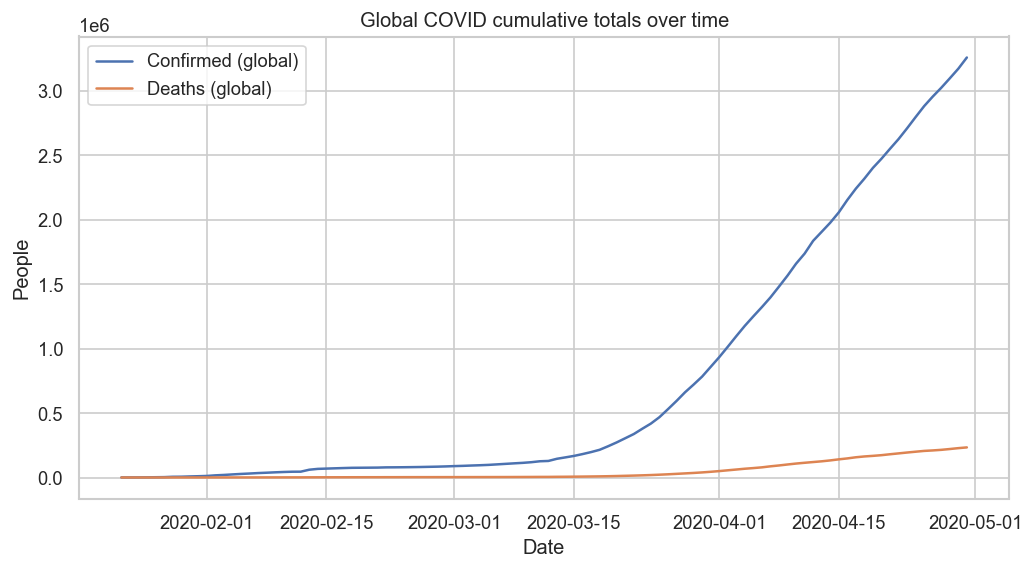

In [40]:
# ---------------------------------------------
# 7) EDA & Visualizations
# ---------------------------------------------
# 7a) Global trend
global_ts = (
    covid_yearly
    .groupby("date", as_index=False)
    .agg(confirmed=("confirmed","sum"), deaths=("deaths","sum"))
    .sort_values("date")
)

plt.figure(figsize=(10,5))
plt.plot(global_ts["date"], global_ts["confirmed"], label="Confirmed (global)")
plt.plot(global_ts["date"], global_ts["deaths"],    label="Deaths (global)")
plt.title("Global COVID cumulative totals over time")
plt.xlabel("Date"); plt.ylabel("People")
plt.legend()
plt.show()



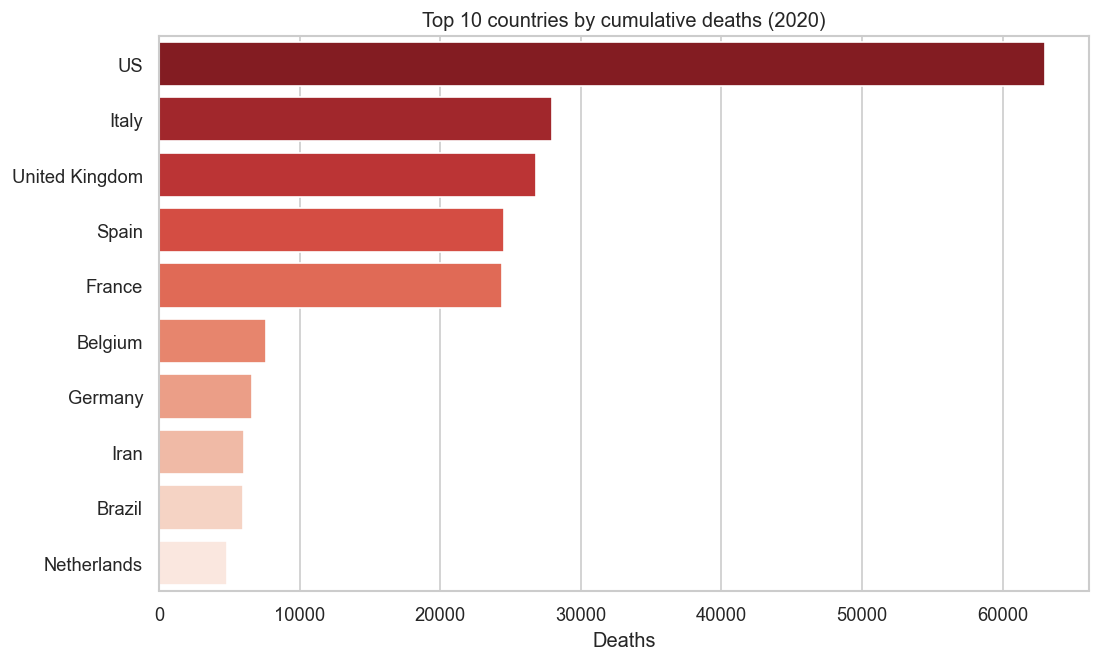

In [41]:
# 7b) Top 10 deaths (2020)
top10_deaths = (
    covid_yearly_last[covid_yearly_last["year"] == 2020]
    .sort_values("deaths", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top10_deaths,
    y="Country/Region", x="deaths",
    hue="Country/Region",   # <--- use hue
    palette="Reds_r",
    dodge=False             # keep bars single
)
plt.legend([],[], frameon=False)  # remove redundant legend
plt.title("Top 10 countries by cumulative deaths (2020)")
plt.xlabel("Deaths"); plt.ylabel("")
plt.show()

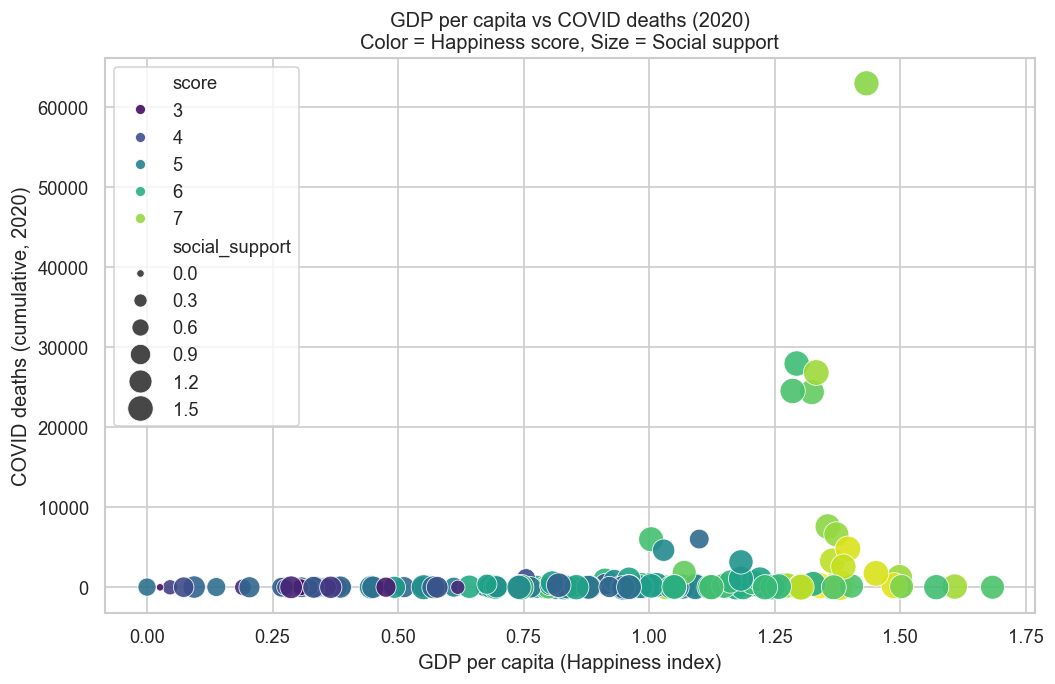

In [42]:
# 7c) GDP per capita vs COVID deaths
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=merged[merged["year"]==2020],
    x="gdp_per_capita", y="deaths",
    hue="score", size="social_support",
    palette="viridis", sizes=(20, 250), alpha=0.9, edgecolor="white", linewidth=0.5
)
plt.title("GDP per capita vs COVID deaths (2020)\nColor = Happiness score, Size = Social support")
plt.xlabel("GDP per capita (Happiness index)")
plt.ylabel("COVID deaths (cumulative, 2020)")
plt.show()

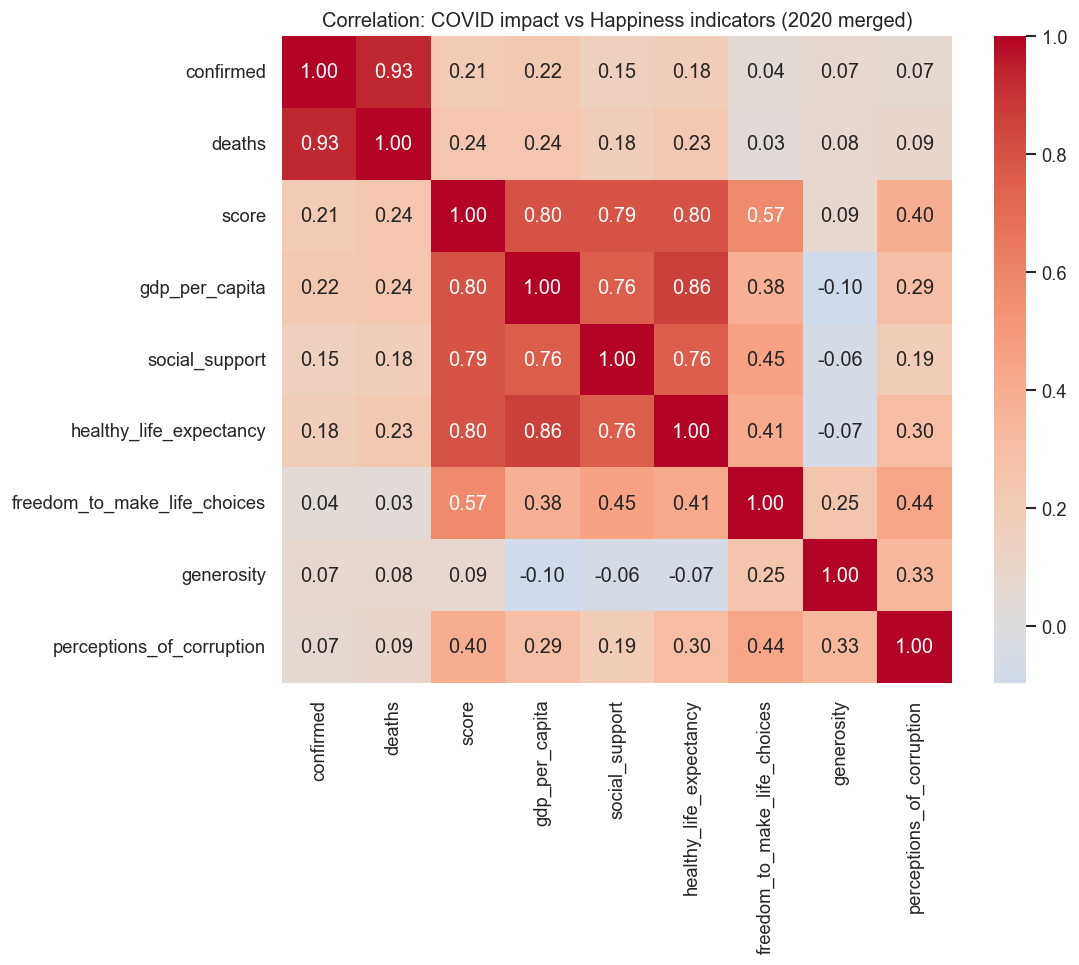

In [43]:
# 7d) Correlation heatmap
corr_cols = [
    "confirmed","deaths","score","gdp_per_capita","social_support",
    "healthy_life_expectancy","freedom_to_make_life_choices",
    "generosity","perceptions_of_corruption"
]
corr = merged[corr_cols].corr()

plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation: COVID impact vs Happiness indicators (2020 merged)")
plt.show()

In [44]:
# ---------------------------------------------
# 8) Notes
# ---------------------------------------------
print("\nNOTES:")
print("- JHU values are cumulative; last available date in 2020 used for '2020 totals'.")
print("- Correlations are descriptive only, not causal.")
print("- Absolute counts used (not per capita).")


NOTES:
- JHU values are cumulative; last available date in 2020 used for '2020 totals'.
- Correlations are descriptive only, not causal.
- Absolute counts used (not per capita).
